In [1]:
import numpy as np
import glob
import os
from matplotlib import pyplot
from matplotlib.image import imread
import matplotlib.ticker as mtick
%matplotlib inline
%pylab inline
import seaborn as sns

from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GaussianNoise, LeakyReLU
from keras.metrics import Precision, Recall
from keras.applications import Xception, VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

from sklearn import metrics

Populating the interactive namespace from numpy and matplotlib


C:\Users\bjane\Miniconda3\envs\learn-env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


In [2]:
# define path to save model
model_path = './Xception_best_model.h5'

callbacks = [EarlyStopping(monitor='val_accuracy', 
                           patience=10,
                           mode='max',
                           verbose=1),
             ModelCheckpoint(model_path,
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max',
                             verbose=0)]

In [3]:
# define model evaluation
def model_evaluation(history, p_r_iteration=2):

    # set context for plots
    sns.set_style('darkgrid') 
    sns.set_context('talk') 
    
    # define number of epochs
    epochs = range(1, len(history.history['accuracy'])+1)
    
    # plot accuracy
    plt.figure(figsize=(15,8))
    pyplot.title("Accuracy") 
    ax = plt.plot(epochs, history.history['accuracy'], color='blue', label='Train Data') 
    ax = plt.plot(epochs, history.history['val_accuracy'], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot recall
    plt.figure(figsize=(15,8))
    pyplot.title("Precision") 
    plt.plot(epochs, history.history['recall_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_recall_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()
    
    # plot precision
    plt.figure(figsize=(15,8))
    pyplot.title("Recall") 
    plt.plot(epochs, history.history['precision_{}'.format(p_r_iteration)], color='blue', label='Train Data') 
    plt.plot(epochs, history.history['val_precision_{}'.format(p_r_iteration)], color='orange', label='Validation Data') 
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
    plt.legend()

In [4]:
# directory path
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'

In [5]:
# create new instances for Xception model
generator_Xception = ImageDataGenerator(rescale = 1.0/255.0,
                                        validation_split=0.10,
                                        horizontal_flip=True)

generator_Xception_test = ImageDataGenerator(rescale = 1.0/255.0)
                                         
# Get all the data in the directory chest_xrays/train and resize
train_gen_Xception = generator_Xception.flow_from_directory(
        train_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64,
        color_mode='rgb',
        subset='training')

# create a validation dataset
val_gen_Xception = generator_Xception.flow_from_directory(
        train_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64,
        color_mode='rgb',
        subset='validation')

# Get all the data in the directory chest_xrays/test and resize
test_gen_Xception = generator_Xception_test.flow_from_directory(
        test_data_dir, 
        target_size=(112, 112), 
        class_mode='binary',
        batch_size=64, 
        color_mode='rgb')

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
# define Xception model
def create_Xception_model(classification_threshold=0.5):

    # load Xception model
    cnn_base = Xception(include_top=False, input_shape=(112, 112, 3))
    
    # do not mark Xception model layers as untrainable
    cnn_base.trainable = False
    
    # initialize model
    model = Sequential()
    
    # add CNN base
    model.add(cnn_base)
    
    # add flattening layer
    model.add(Flatten())
    
    # add 1st dense layer
    model.add(Dense(256, activation=None, kernel_initializer='he_uniform'))
    
    # add Leaky ReLU activation
    model.add(LeakyReLU(0.3))
    
    # dropout
    model.add(Dropout(0.3))
    
    # add 2nd dense layer
    model.add(Dense(128, activation=None, kernel_initializer='he_uniform'))
    
    # add leaky ReLU activation
    model.add(LeakyReLU(0.3))
    
    # dropout
    model.add(Dropout(0.3))
    
    # add 3rd dense layer
    model.add(Dense(64, activation=None, kernel_initializer='he_uniform'))
    
    # add leaky ReLU activation
    model.add(LeakyReLU(0.3))

    # add output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

    # custom decaying optimizer
    #optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.SGD(lr=0.001, momentum=0.9)
    
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(classification_threshold), 
                                                                         Recall(classification_threshold)])
    
    return model

In [7]:
# create Xception model
Xception_model = create_Xception_model(classification_threshold=0.50)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# train model
history_Xception = Xception_model.fit_generator(train_gen_Xception, steps_per_epoch=len(train_gen_Xception), 
                                         epochs=50, validation_data=val_gen_Xception, validation_steps=len(val_gen_Xception),
                                         callbacks=callbacks)


Epoch 1/50
74/74 [==============================] - 307s 4s/step - loss: 0.7599 - accuracy: 0.8503 - precision_1: 0.8941 - recall_1: 0.9057 - val_loss: 2.0659 - val_accuracy: 0.8503 - val_precision_1: 0.8635 - val_recall_1: 0.9483
Epoch 2/50
74/74 [==============================] - 324s 4s/step - loss: 0.3596 - accuracy: 0.9067 - precision_1: 0.9315 - recall_1: 0.9438 - val_loss: 0.0788 - val_accuracy: 0.8292 - val_precision_1: 0.9005 - val_recall_1: 0.8656
Epoch 3/50
74/74 [==============================] - 336s 5s/step - loss: 0.3311 - accuracy: 0.9037 - precision_1: 0.9291 - recall_1: 0.9424 - val_loss: 0.6247 - val_accuracy: 0.8177 - val_precision_1: 0.8160 - val_recall_1: 0.9742
Epoch 4/50
74/74 [==============================] - 310s 4s/step - loss: 0.2978 - accuracy: 0.9054 - precision_1: 0.9341 - recall_1: 0.9389 - val_loss: 0.9935 - val_accuracy: 0.7716 - val_precision_1: 0.7680 - val_recall_1: 0.9922
Epoch 5/50
74/74 [==============================] - 306s 4s/step - loss: 0.

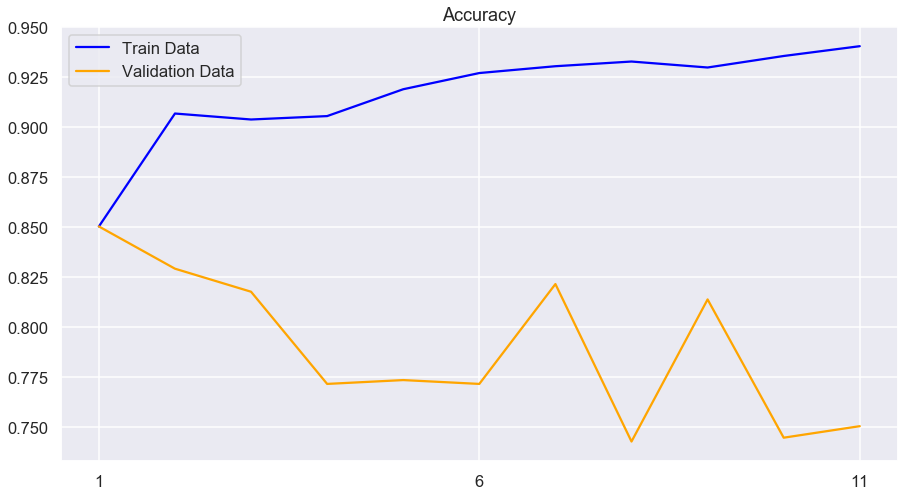

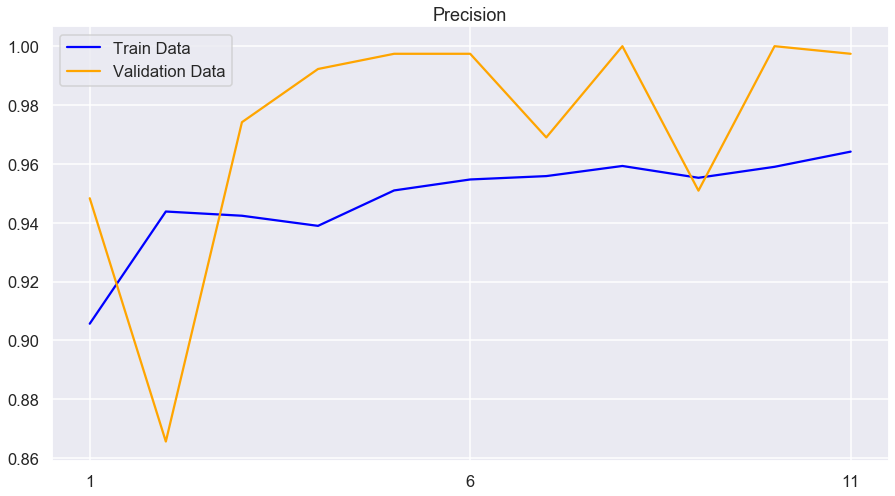

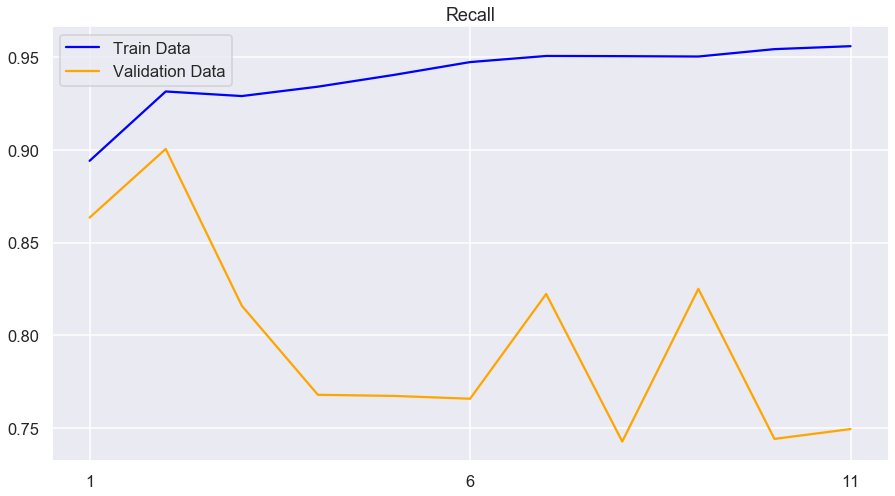

In [11]:
# evaluate model
model_evaluation(history_Xception, p_r_iteration=1)

In [12]:
# evaluate on test set

Xception_test_accuracy = Xception_model.evaluate_generator(test_gen_Xception, steps=len(test_gen_Xception))[1]
Xception_test_precision = Xception_model.evaluate_generator(test_gen_Xception, steps=len(test_gen_Xception))[2]
Xception_test_recall = Xception_model.evaluate_generator(test_gen_Xception, steps=len(test_gen_Xception))[3]

print("Test Set Accuracy: {}%".format(Xception_test_accuracy*100))
print("Test Set Precision: {}%".format(Xception_test_precision*100))
print("Test Set Recall: {}%".format(Xception_test_recall*100))

Test Set Accuracy: 63.30128312110901%
Test Set Precision: 63.047003746032715%
Test Set Recall: 99.74358677864075%


In [16]:
# plot confusion matrix for test set
Y_pred_Xception = Xception_model.predict_generator(test_gen_Xception, 10, workers=0)
y_pred_Xception = np.where(Y_pred_Xception > 0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(test_gen_Xception.classes, y_pred_Xception)
print(cm)
print('Classification Report')
print(metrics.classification_report(test_gen_Xception.classes, y_pred_Xception))

Confusion Matrix
[[  1 233]
 [  6 384]]
Classification Report
              precision    recall  f1-score   support

           0       0.14      0.00      0.01       234
           1       0.62      0.98      0.76       390

    accuracy                           0.62       624
   macro avg       0.38      0.49      0.39       624
weighted avg       0.44      0.62      0.48       624

